<a href="https://colab.research.google.com/github/Rajeeb321123/Deep-learning-tensorFlow-Journey/blob/master/06_transfer_learning_in_tensorflow_part3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Leraning with TensorFlow Part 3: Scaling up (🍔👁️ Food Vision mini)


We've  seen the power of transfer learning features extraction and fine-tunnnig, now it's time to scale up to all of the classes in Food101 (101 total classes of food).

Our goal is to beat the original Food101 paper with 10% of the training (leveraging power of deep learning).

Original Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

OUr baseline is to beat 50.71% accuracy accross 101 class.

In [1]:
# Check to see if we're using a GPU
!nvidia-smi

Sun Mar 10 05:54:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Creating Hepler Functions

In previous notebooks, We create various functions to assist us to different task. Let's download them

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-03-10 05:54:34--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-03-10 05:54:35 (54.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of hepler functionsj in our note book
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

The data we're downloading comes from the original Food101 dataset but has been preprocessed using the image_data_modification notebook - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2024-03-10 05:54:39--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.207, 142.250.4.207, 172.253.118.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  19.2MB/s    in 90s     

2024-03-10 05:56:09 (17.3 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
unzip_data("101_food_classes_10_percent.zip")

In [6]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [7]:
# How many image/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/peking_duck'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/deviled_eggs'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/donuts'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/onion_rings'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/churros'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pancakes'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/nachos'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/oysters'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '101_food_classes_10

In [8]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE =(224, 224)

In [9]:
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) #don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10 % of 101 food classes

Here are the steps we're going to take:
* Create a ModelCheckpoint callback
* Create a data augmentaion layer to build data augmentaion right into the model
* Build a headless (no top layers) functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full classes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)
                                                                              

In [10]:
# Create checkpoint callback
checkpoint_path = "101_food_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy", # check for val_accuracy
                                                         save_best_only=True) # save only with highest val_accuracy

In [11]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

In [12]:
# Setup data augmentaion
data_augmentaion = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    # preprocessing.Rescaling(1/255.) # rescale inputs of images to between 0 and 1, required for models like ResNet50
], name = "data_augmentaion")

In [13]:
# Setup the base model and freeze it's layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # mean we dont want output neurons
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name = "input_layer")
x = data_augmentaion(inputs) # augment images (only happens during training phase)
x = base_model(x, training=False) # put these model in inference mode so weights which need to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x) # 2D because we are working with 2D images
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 2s 0us/step


In [14]:
# Get a summary of model we've created
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentaion (Sequenti  (None, None, None, 3)     0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_avg_pool_layer (Glo  (None, 1280)              0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [16]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data = test_data,
                                           validation_steps = int(0.15 * len(test_data)), # validate on only 15% of data during training,
                                           callbacks=[checkpoint_callback]
                                           )

Epoch 1/5
237/237 [==============================] - 158s 622ms/step - loss: 3.3678 - accuracy: 0.2730 - val_loss: 2.5471 - val_accuracy: 0.4303
Epoch 2/5
237/237 [==============================] - 111s 462ms/step - loss: 2.1918 - accuracy: 0.4978 - val_loss: 2.1380 - val_accuracy: 0.4801
Epoch 3/5
237/237 [==============================] - 92s 388ms/step - loss: 1.8278 - accuracy: 0.5628 - val_loss: 1.9658 - val_accuracy: 0.5013
Epoch 4/5
237/237 [==============================] - 81s 339ms/step - loss: 1.6074 - accuracy: 0.6117 - val_loss: 1.8751 - val_accuracy: 0.5132
Epoch 5/5
237/237 [==============================] - 73s 306ms/step - loss: 1.4624 - accuracy: 0.6380 - val_loss: 1.8356 - val_accuracy: 0.5212


In [ ]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results
#790/790 [==============================] - 57s 72ms/step - loss: 1.5835 - accuracy: 0.5839
#[1.5835423469543457, 0.5838811993598938]

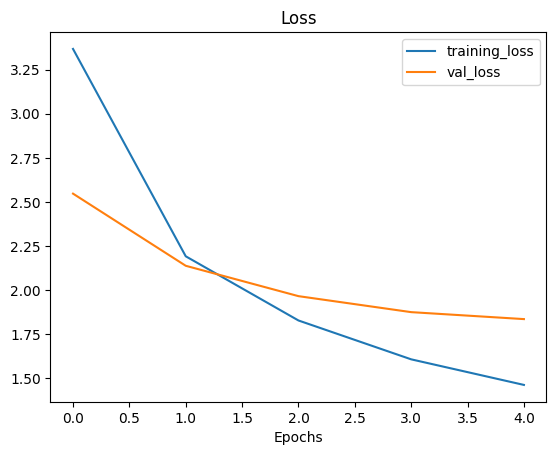

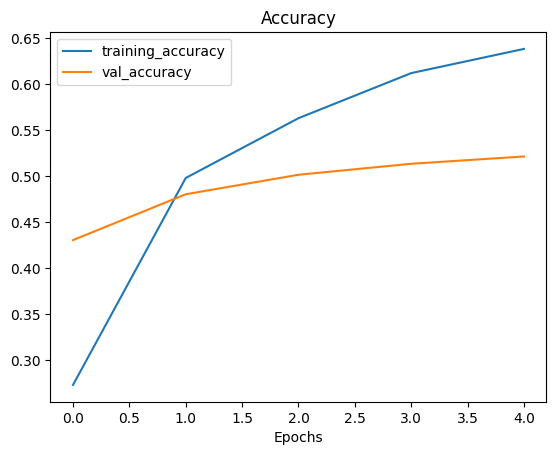

In [19]:
plot_loss_curves(history_all_classes_10_percent)

> 🤔 **Question** What do these curves suggest? Hint: ideally, the two curves should be very similar to each other, if not...

If not it may suggest that our model is overfitting (performing too well on the training data and not generalizing to unseen data).

## Fine-Tuning

In [20]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except last 5 (only 5 because our feature extractor is doing pretty well)
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# Recompile model with lower learning (it's typically best practice to lower the learning rate while fine-tunning)
model.compile(loss="categorical_entropy",
              optimizer = tf.keras.optimizer.Adam(learning_Rate=0.0001), # learning rate lowered by 10x
              metrics=["accuracy"])

In [21]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentaion True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [22]:
# Check which layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer.name, layer.trainable)

input_1 False
rescaling False
normalization False
rescaling_1 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_proj

In [23]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs (feature extraction), this is the total number of epochs we're after (5 + 5 = 10)

# Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                    epochs=fine_tune_epochs, # 5 epochs has already been done, here only 5 epochs
                                                    validation_data=test_data,
                                                    validation_steps=int(0.15 * len(test_data)),
                                                    initial_epoch=history_all_classes_10_percent.epoch[-1]) # We start at 5 epochs as we already did 5 epochs in feature extraction

Epoch 5/10
237/237 [==============================] - 74s 312ms/step - loss: 1.3368 - accuracy: 0.6661 - val_loss: 1.7887 - val_accuracy: 0.5283
Epoch 6/10
237/237 [==============================] - 70s 293ms/step - loss: 1.2363 - accuracy: 0.6948 - val_loss: 1.7560 - val_accuracy: 0.5373
Epoch 7/10
237/237 [==============================] - 64s 267ms/step - loss: 1.1382 - accuracy: 0.7189 - val_loss: 1.7610 - val_accuracy: 0.5371
Epoch 8/10
237/237 [==============================] - 57s 240ms/step - loss: 1.0765 - accuracy: 0.7360 - val_loss: 1.7732 - val_accuracy: 0.5310
Epoch 9/10
237/237 [==============================] - 58s 241ms/step - loss: 1.0151 - accuracy: 0.7526 - val_loss: 1.7737 - val_accuracy: 0.5373
Epoch 10/10
237/237 [==============================] - 56s 235ms/step - loss: 0.9508 - accuracy: 0.7667 - val_loss: 1.7524 - val_accuracy: 0.5418


In [24]:
# Evaluate on the whole test data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)

790/790 [==============================] - 56s 71ms/step - loss: 1.4974 - accuracy: 0.6006


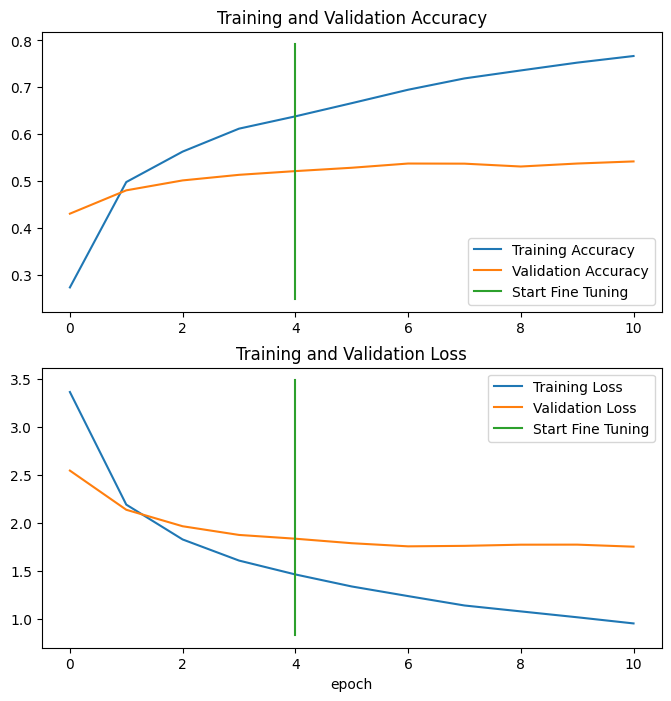

In [25]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs = 5)

## Saving and loading our model

To use our model in an external applicaiton, we'll need to save it and export somewhere

In [26]:
# Save our fine-tunning model
model.save("drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_big_dog_model")

In [28]:
# Load and evaluate saved model
loaded_model = tf.keras.models.load_model("drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_big_dog_model")

In [29]:
# Evaluate loaded model and compare performance of pre-saved model
loaded_model_results =loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 63s 78ms/step - loss: 1.4974 - accuracy: 0.6006


In [32]:
# The results from our loaded model above should be very similar to results below
print(f"loaded_model:results:{loaded_model_results} \n all_classes_10_percent_fine_tune_results: {all_classes_10_percent_fine_tune_results}")

loaded_model:results:[1.4974035024642944, 0.6006336808204651] 
 all_classes_10_percent_fine_tune_results: [1.4974035024642944, 0.6006336808204651]


## Evaluating the performance of the big dog model across all different classes

Let's make some predictions visualize them and then later find out which predictions were the **"most wrong"**.